In [1]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm

In [2]:
def plot_blocks(page_df, draw, color = '#660044', w = 2):
    blocks = page_df['block_no'].unique()
    """for b in blocks:
        lines = page_df[page_df['block_no'] == b]['line_no'].unique()
        for l in lines:
            cond = (page_df['line_no'] == l) & (page_df['block_no'] == b)
            words = page_df[cond]['word_no'].unique()
            page_df = page_df.copy()
            for w in words:
                x0 = page_df[(cond) & (page_df['word_no'] == w)]['x0'].item()
                y0 = page_df[(cond) & (page_df['word_no'] == w)]['y0'].item()
                x1 = page_df[(cond) & (page_df['word_no'] == w)]['x1'].item()
                y1 = page_df[(cond) & (page_df['word_no'] == w)]['y1'].item()
                draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = w)
    """
    for b in blocks:
        sub_df = page_df[page_df['block_no'] == b]
        if sub_df['paragraph_state'].any() == "start":
            color = "#8ca4de"
        if sub_df['paragraph_state'].any() == "cont":
            color = "#b9ebbd"
        x0, y0, x1, y1 = sub_df['x0'].min(), sub_df['y0'].min(), sub_df['x1'].max(), sub_df['y1'].max() 
        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = w)
    #for index, row in page_df.iterrows():
    #    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1'] 
    #    draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = w)

In [59]:
#pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf"
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
#index = range(616, 639)
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.page_count)]
#index = list(range(555, 583))

pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
#index = range(616, 639)

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [60]:
#Setting up files and directories for saving the results
SCRIPT_NAME = "main_flora_playground_july14th"
SCRIPT_OUTPUT_PATH = "../output/main_text/" + SCRIPT_NAME + "/"
DATE_STR = datetime.now().strftime("%Y_%m_%d") 
TIME_STR = datetime.now().strftime("%H%M")
QUICK_FIX = False
TAIL_STR = ''

if QUICK_FIX:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/QuickFix/" 
    #TAIL_STR = '_' + DATE_STR + '_' + TIME_STR
else:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/" + TIME_STR + "/"

try:
    os.makedirs(OUTPUT_PATH)
except FileExistsError:
    # directory already exists
    pass

In [61]:
def valid(word):
    """
    valid words are words that are:
    - at least 2 characters
        - unless it's x (symbol for hybrid)
    """
    return (not bool(re.search(r"[0-9]+[,.]?", word))) and \
            (word != 'NOUVELLE' and word != 'FLORE') and \
            (len(word) > 1 or \
                word == 'x' or word == 'X' or word == '×' or word == r'\u00D7') and \
            ''.join(e for e in word if e.isalpha()).isalpha()
    

In [66]:
def preprocessing(page_num, indent_err = 27):
    
    #initiate dataframe
    page_df = pd.DataFrame(pages[page_num].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])
    
    #add page number to dataframe
    page_df['page_num'] = np.array([page_num]*page_df.shape[0])
    #initiate all columns that will be added
    page_df['genus'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_genus'] = np.array([np.NaN]*page_df.shape[0])
    page_df['epithet'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_epithet'] = np.array([np.NaN]*page_df.shape[0])
    page_df['author'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_author'] = np.array([np.NaN]*page_df.shape[0])
    page_df['infra'] = np.array([np.NaN]*page_df.shape[0])
    page_df['draw_infra'] = np.array([np.NaN]*page_df.shape[0])
    page_df['taxon rank'] = np.array([np.NaN]*page_df.shape[0])
    page_df['error_check'] = np.array([np.NaN]*page_df.shape[0])
    #updating coordinates to represent target DPI
    page_df['x0'], page_df['y0'], page_df['x1'], page_df['y1'] = page_df['in_x0']*TARGET_DPI/ 72, page_df['in_y0']*TARGET_DPI/ 72, page_df['in_x1']*TARGET_DPI/ 72, page_df['in_y1']*TARGET_DPI/ 72
    #get x corner coordinates 
    x_min = page_df['x0'].min()
    x_max = page_df['x1'].max()

    y_max = page_df['y1'].max()

    #Remove the extra flore - 18 at page 545
    #if page_num == index[4]:
    #    page_df = page_df[~((page_df["word"] == 'Flore') & (page_df['y1'] == y_max))]
    #invalid words dataframe -- for error checking
    #pruned_words_df = page_df[~page_df["word"].apply(valid)].reset_index()
    #prune out invalid words (based on function valid)
    all_df = page_df.copy()
    #page_df = page_df[page_df["word"].apply(valid)].reset_index() -- let's not filter out anything for now! 
    
    indent_groups = []
    blocks = page_df['block_no'].unique()
    for b in blocks:
        lines = page_df[page_df['block_no'] == b]['line_no'].unique()
        for l in lines:
            #reset word_no values (useful for cases where word that was originally at 0th index was pruned out)
            cond = (page_df['line_no'] == l) & (page_df['block_no'] == b)
            num_words = len(page_df[cond]['word_no'])
            page_df.loc[cond, 'word_no'] = np.arange(num_words).astype(int) #this is slowww
            #set column number (0 or 1)
            x_0 = page_df[cond]['x0'].min()
            #THIS DOESN'T WORK AAAA -- issue was with line no thing
            if not np.isnan(x_0):
                page_df.loc[cond, 'col_no'] = np.array([int(x_0 > ((x_min + x_max) / 2))]*num_words).astype(int)

                #initiate indent groups -- only first word should get an indent_group value 
                new_group = True
                for g_i in range(len(indent_groups)):
                    g = indent_groups[g_i]
                    g_arr = np.array(g)
                    if x_0 <= np.mean(g_arr) + indent_err and x_0 >= np.mean(g_arr) - indent_err:
                        g.append(x_0)
                        new_group = False
                        page_df.loc[cond, 'indent_group'] = np.array([g_i]*num_words).astype(int)
                if new_group:
                    indent_groups.append([x_0])
                    g_i = len(indent_groups) - 1
                    page_df.loc[cond, 'indent_group'] = np.array([g_i]*num_words).astype(int)

    #print("indent groups:", indent_groups)
    #return updated page_df, pruned_words_df, indent groups
    return all_df, page_df.reset_index()

#https://stackoverflow.com/questions/53468558/adding-image-to-pandas-dataframe

In [67]:
result_ims = []
df_dict = {}

for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    all_df, page_df = preprocessing(page_num, indent_err = 30)
    df_dict[page_num] = {"all" : all_df, "pruned" : page_df}
    #pd.DataFrame(pages[page_num].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])
    #page_df['x0'], page_df['y0'], page_df['x1'], page_df['y1'] = page_df['in_x0']*TARGET_DPI/ 72, page_df['in_y0']*TARGET_DPI/ 72, page_df['in_x1']*TARGET_DPI/ 72, page_df['in_y1']*TARGET_DPI/ 72
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    plot_blocks(page_df, draw, color = '#660044', w = 2)
    result_ims.append(image)

result_ims[0].save(OUTPUT_PATH + 'block_regions_third_quarter.pdf',save_all=True, append_images=result_ims[1:])

100%|██████████| 160/160 [00:35<00:00,  4.52it/s]


In [68]:
#types = ['genus', 'epithet', 'infra', 'author', 'misc.']
def n_leftmost_indent(df, n):
    """return a tuple with at most 3 elements each element itself is a tuple containing indent group, mean, group len"""
    indent_groups = [(g, df[(df['indent_group'] == g) & (df['word_no'] == 0)]['x0'].mean(), len(df[(df['indent_group'] == g) & (df['word_no'] == 0)]['x0'])) for g in df['indent_group'].unique()]
    indent_groups.sort(key = lambda x : x[1])
    #print(indent_groups[:n])
    return indent_groups[:n]

In [69]:
result_ims = []
df_dict = {}

for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    all_df, page_df = preprocessing(page_num, indent_err = 30)
    df_dict[page_num] = {"all" : all_df, "pruned" : page_df}

    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    plot_blocks(page_df, draw, color = '#660044', w = 2)
    result_ims.append(image)

100%|██████████| 160/160 [00:35<00:00,  4.57it/s]


In [72]:
def set_paragraph_indent(all_df, page_df):
    leftmost_3_indents = n_leftmost_indent(page_df, 2) #for vol1 only 2 indentations will be given 
    cont_indent, start_indent = [el[0] for el in leftmost_3_indents]
    
    blocks = page_df['block_no'].unique()
    for b in blocks:
        if b == blocks[0]:
            print(cont_indent, start_indent)
            return  all_df[all_df['block_no'] == b]
        block_cond = all_df['block_no'] == b
        if page_df['indent_group'].min() == cont_indent: #mostly .min() is place holder... makes sense though 
            all_df.loc[block_cond, 'paragraph_state'] = "cont"
        if page_df['indent_group'].min() == start_indent:
            all_df.loc[block_cond, 'paragraph_state'] = "start"
        else:
            all_df.loc[block_cond, 'paragraph_state'] = "misc"
    return all_df

In [100]:
def set_paragraph_indent(all_df):
    leftmost_3_indents = n_leftmost_indent(all_df, 2) #for vol1 only 2 indentations will be given 
    cont_indent, start_indent = [el[0] for el in leftmost_3_indents]
    
    blocks = all_df['block_no'].unique()
    for b in blocks:
        block_cond = all_df['block_no'] == b
        #print(all_df['indent_group'][block_cond].min(), cont_indent, start_indent)
        if all_df[block_cond]['indent_group'].min() == cont_indent: #mostly .min() is place holder... makes sense though 
            all_df.loc[block_cond, 'paragraph_state'] = "cont"
            #print("should work")
        if all_df[block_cond]['indent_group'].min() == start_indent:
            all_df.loc[block_cond, 'paragraph_state'] = "start"
            #print("should work")
        else:
            all_df.loc[block_cond, 'paragraph_state'] = "misc"
    return all_df

In [101]:
df = set_paragraph_indent(page_df)
df[df['block_no'] == 1]['indent_group'].min()
df[df['block_no'] == 1]['indent_group'].unique()

array([2.])

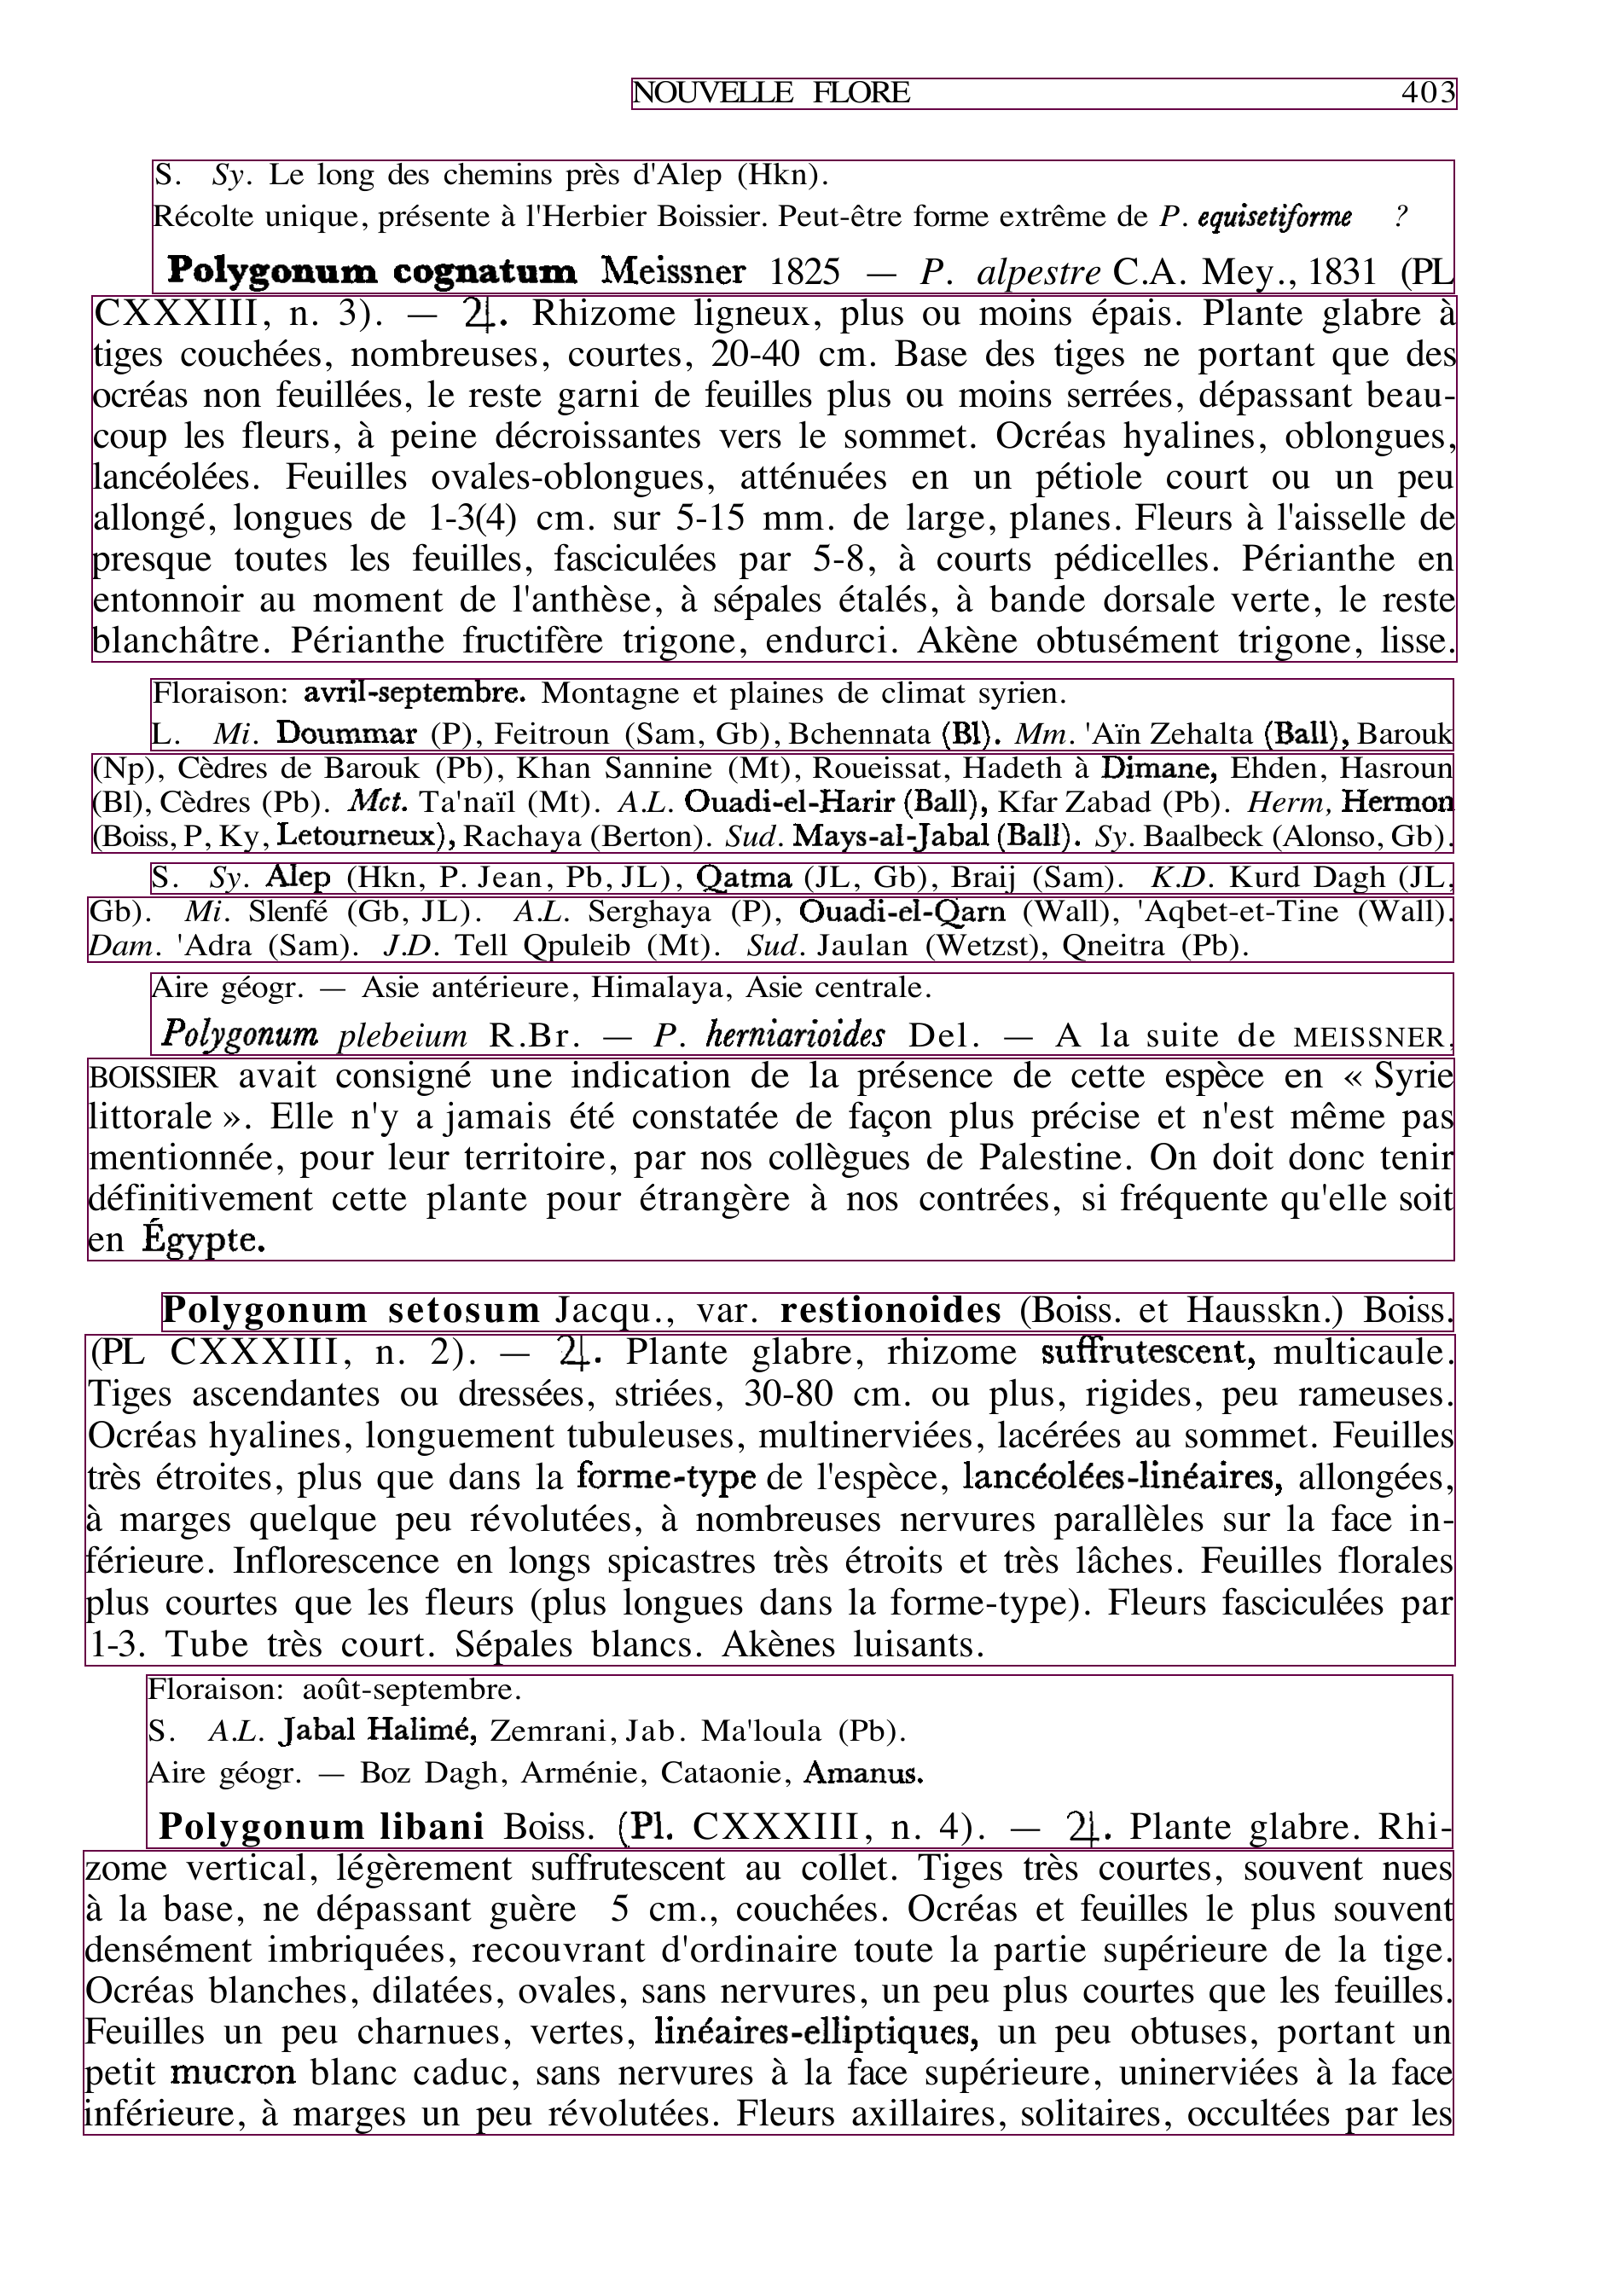

In [108]:
set_paragraph_indent(page_df)
result_ims[480-doc.page_count*2//4]

# LATER

In [109]:
def plot_blocks_by_cond(page_df, draw, w = 2):
    blocks = page_df['block_no'].unique()
    """for b in blocks:
        lines = page_df[page_df['block_no'] == b]['line_no'].unique()
        for l in lines:
            cond = (page_df['line_no'] == l) & (page_df['block_no'] == b)
            words = page_df[cond]['word_no'].unique()
            page_df = page_df.copy()
            for w in words:
                x0 = page_df[(cond) & (page_df['word_no'] == w)]['x0'].item()
                y0 = page_df[(cond) & (page_df['word_no'] == w)]['y0'].item()
                x1 = page_df[(cond) & (page_df['word_no'] == w)]['x1'].item()
                y1 = page_df[(cond) & (page_df['word_no'] == w)]['y1'].item()
                draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = w)
    """
    for b in blocks:
        sub_df = page_df[page_df['block_no'] == b]
        x0, y0, x1, y1 = sub_df['x0'].min(), sub_df['y0'].min(), sub_df['x1'].max(), sub_df['y1'].max() 
        if sub_df['paragraph_state'].any() == "start":
            color = '#e3a79f'
        elif sub_df['paragraph_state'].any() == "cont": 
            color = '#9fe3e1'
        elif sub_df['paragraph_state'].any() == "misc": 
            color = '#eaebb5'
        else: 
            color = '#ffffff'
        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = w)
    #for index, row in page_df.iterrows():
    #    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1'] 
    #    draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = w)

In [112]:
paragraph_result_ims = []
for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    all_df, page_df = df_dict[page_num]["all"], df_dict[page_num]["pruned"]
    page_df = set_paragraph_indent(page_df)
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    plot_blocks(page_df, draw, w = 2)
    paragraph_result_ims.append(image)

paragraph_result_ims[0].save(OUTPUT_PATH + 'paragraph_states_third_quarter.pdf',save_all=True, append_images=paragraph_result_ims[1:])

100%|██████████| 160/160 [00:32<00:00,  5.00it/s]


In [13]:
(all_df['paragraph_state'] == 'misc').any()

True

In [14]:
p_indent = "SPACE BETWEEN INDENT 1 AND INDENT 2"

CENTER = "end indnent and begenning indent are more or less the same (so centered around center)"
LEFT_ALIGN = "GREATER THAN 1.5 indent and stuck to the left"
RIGHT_ALIGN = "Just the rest? yup"

"if indented paragraph thingi -- break it down int o different multiple lines" 

"should try wihtout pruning?"

"transition to using get_tex('dict') and doing the pandas based on that + enumerate (for getting block nums and stuff) :)"

""



''